# Chroma Vector Database Tutorial


In [ ]:
!pip install -q chromadb transformers #이미지를 vectror로 변환해 huggingface에 있는 모델을 사용하기 위해서 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.6/86.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 98.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.7/922.7 kB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 104.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 105.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.3 MB

## Dataset

Food-11 데이터셋 중 evaluation 데이터 10장씩

https://www.kaggle.com/datasets/trolukovich/food11-image-dataset

In [ ]:
!wget -q https://github.com/kairess/toy-datasets/raw/master/Food-11.zip
!unzip -q Food-11.zip

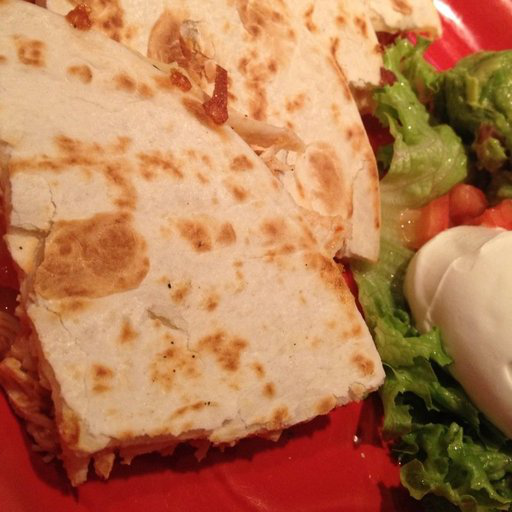

In [ ]:
from PIL import Image
img = Image.open("test/Bread/0.jpg")
img

## Image Vectorizer 모델 로드

https://huggingface.co/facebook/dino-vits16

In [ ]:
from transformers import ViTFeatureExtractor, ViTModel

feature_extractor = ViTFeatureExtractor.from_pretrained('facebook/dino-vits16') #vision transformer 모델사용 
model = ViTModel.from_pretrained('facebook/dino-vits16').to("cuda")

print("Models loaded!")

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Models loaded!


## 임베딩

In [ ]:
img_tensor = feature_extractor(images=img, return_tensors="pt").to("cuda")
outputs = model(**img_tensor)

embedding = outputs.pooler_output.detach().cpu().numpy().squeeze() #최종 pooler_output --> embedding vector 1차원 배열로 변환한다.

embedding #384차원 vector

array([-0.26670137,  0.99412304, -0.8850037 ,  0.9877083 , -0.999103  ,
       -0.98183113, -0.9508347 ,  0.63154995,  0.9991714 , -0.13947165,
       -0.13099563,  0.9283047 ,  0.10458171,  0.20590857,  0.9845212 ,
       -0.8728759 , -0.9856119 ,  0.83325547,  0.993111  , -0.82711726,
        0.56515086, -0.93583924,  0.97005177,  0.04766414,  0.72533274,
        0.6806246 ,  0.38755006,  0.9851302 , -0.24272375, -0.14201999,
       -0.3673356 , -0.19503732,  0.9745307 , -0.9985101 , -0.92725736,
        0.09450911,  0.9508288 ,  0.5775569 ,  0.71298945, -0.99871063,
       -0.55998886, -0.7505804 , -0.7576935 , -0.78346425, -0.87986887,
        0.95861024, -0.85621077, -0.5081064 ,  0.8599547 ,  0.09166869,
        0.8714025 , -0.76751494,  0.98141   ,  0.94460684,  0.13085738,
       -0.98916835, -0.8164364 , -0.9637364 ,  0.97936666,  0.97674894,
       -0.52869475, -0.98509955, -0.9692595 , -0.8402222 , -0.8736197 ,
        0.11561581,  0.55144626,  0.49563655,  0.99070275,  0.55

In [ ]:
embedding.shape

(384,)

## Chroma DB 시작

https://www.trychroma.com

In [ ]:
import chromadb

client = chromadb.Client()

collection = client.create_collection("foods") #foods라는 컬렉션을 만들어줌

## 모든 이미지 벡터화

In [ ]:
from glob import glob

img_list = sorted(glob("test/*/*.jpg"))

len(img_list)

110

## 임베딩을 데이터베이스에 저장

In [ ]:
from tqdm import tqdm

embeddings = []
metadatas = []
ids = []

for i, img_path in enumerate(tqdm(img_list)): #tqdm은 얼마나 오래 걸리는지를 표시하는 시간
    img = Image.open(img_path)
    cls = img_path.split("/")[1]

    img_tensor = feature_extractor(images=img, return_tensors="pt").to("cuda")
    outputs = model(**img_tensor)

    embedding = outputs.pooler_output.detach().cpu().numpy().squeeze()
    embeddings.append(embedding.tolist())

    metadatas.append({
        "url": img_path,
        "name": cls
    })

    ids.append(str(i))

print("Done!")

collection.add(
    embeddings=embeddings,
    metadatas=metadatas,
    ids=ids,
)

100%|██████████| 110/110 [00:04<00:00, 24.94it/s]


Done!


## Test1

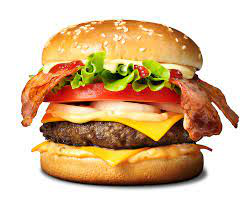

In [ ]:
import requests

# Load the image
test_img = Image.open("/content/test/download.jpg")
#test_img = Image.open(requests.get("https://i.imgur.com/4I0IhII.jpeg", stream=True).raw).convert("RGB")

test_img

In [ ]:
test_img_tensor = feature_extractor(images=test_img, return_tensors="pt").to("cuda")
test_outputs = model(**test_img_tensor)

test_embedding = test_outputs.pooler_output.detach().cpu().numpy().squeeze() 

test_embedding=test_embedding.tolist()

In [ ]:
query_result = collection.query(
    query_embeddings=test_embedding,
    n_results=3,
)

query_result

{'ids': [['8', '2', '103']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'metadatas': [[{'url': 'test/Bread/8.jpg', 'name': 'Bread'},
   {'url': 'test/Bread/2.jpg', 'name': 'Bread'},
   {'url': 'test/Vegetable-Fruit/3.jpg', 'name': 'Vegetable-Fruit'}]],
 'distances': [[212.14572143554688, 270.7365417480469, 306.1700134277344]]}

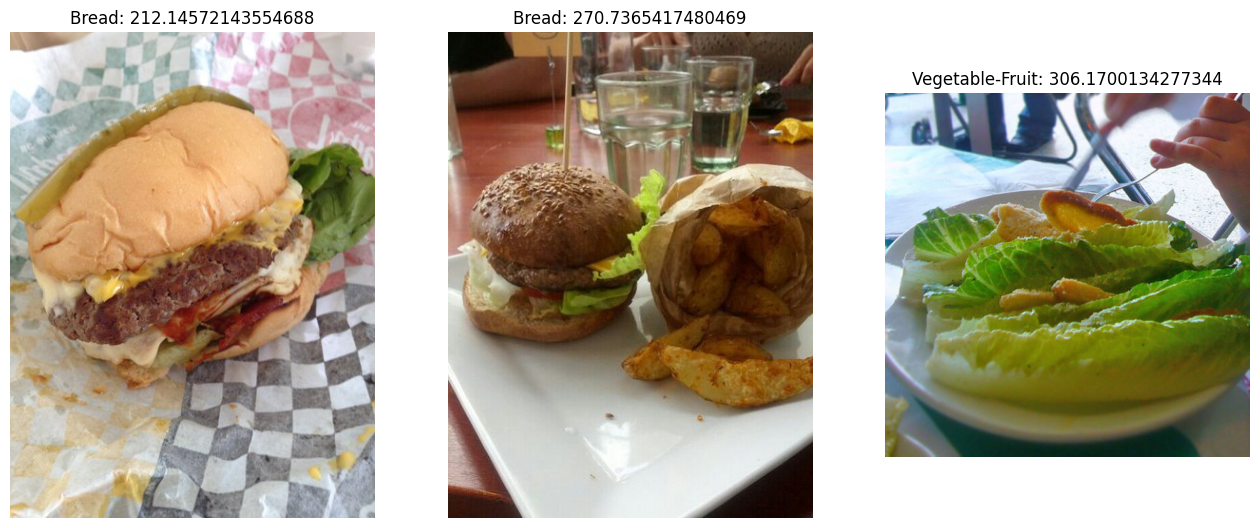

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(16, 10))

for i, metadata in enumerate(query_result["metadatas"][0]):
    distance = query_result["distances"][0][i]

    axes[i].imshow(Image.open(metadata["url"]))
    axes[i].set_title("{}: {}".format(metadata["name"], distance))
    axes[i].axis("off")

## 테스트를 위한 함수화

In [ ]:
def query(img_url, n_results=3):
    #test_img = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
    test_img = Image.open(img_url)
    test_img_tensor = feature_extractor(images=test_img, return_tensors="pt").to("cuda")
    test_outputs = model(**test_img_tensor)

    test_embedding = test_outputs.pooler_output.detach().cpu().numpy().squeeze()
    test_embedding = test_embedding.tolist()
    query_result = collection.query(
        query_embeddings=[test_embedding],
        n_results=n_results,
    )

    fig, axes = plt.subplots(1, 4, figsize=(16, 10))

    axes[0].imshow(test_img)
    axes[0].set_title("Query")
    axes[0].axis("off")

    for i, metadata in enumerate(query_result["metadatas"][0]):
        distance = query_result["distances"][0][i]

        axes[i+1].imshow(Image.open(metadata["url"]))
        axes[i+1].set_title("{}: {}".format(metadata["name"], distance))
        axes[i+1].axis("off")

    return query_result

## Test2

{'ids': [['8', '2', '103']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'metadatas': [[{'url': 'test/Bread/8.jpg', 'name': 'Bread'},
   {'url': 'test/Bread/2.jpg', 'name': 'Bread'},
   {'url': 'test/Vegetable-Fruit/3.jpg', 'name': 'Vegetable-Fruit'}]],
 'distances': [[212.14572143554688, 270.7365417480469, 306.1700134277344]]}

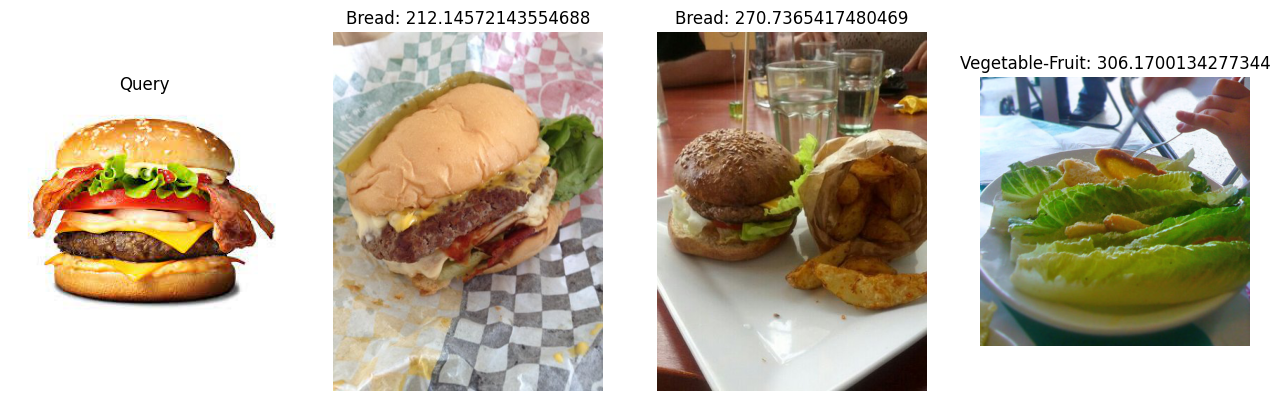

In [ ]:
query("/content/test/download.jpg")

{'ids': [['83', '77', '59']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'metadatas': [[{'url': 'test/Seafood/3.jpg', 'name': 'Seafood'},
   {'url': 'test/Rice/7.jpg', 'name': 'Rice'},
   {'url': 'test/Meat/9.jpg', 'name': 'Meat'}]],
 'distances': [[222.7682647705078, 242.94064331054688, 245.1465606689453]]}

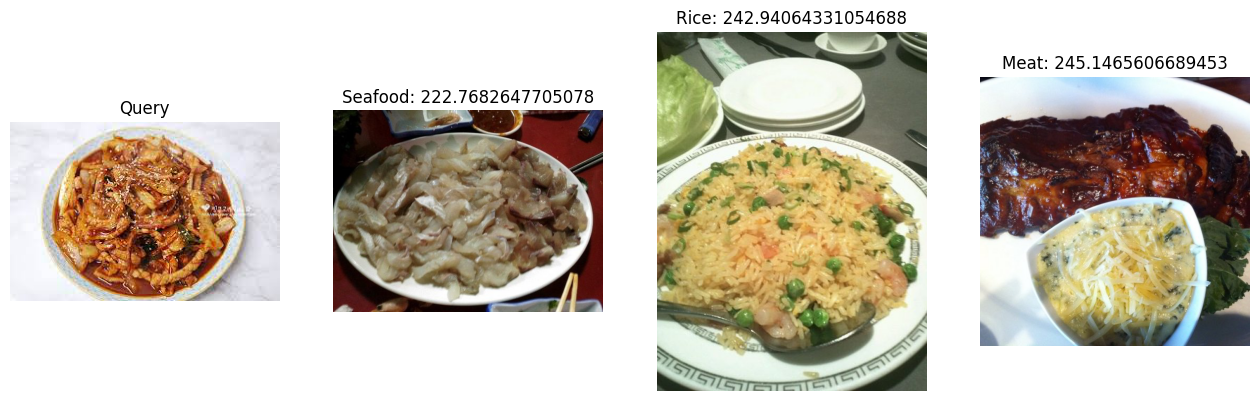

In [ ]:
query("/content/test/download.jpg")

{'ids': [['72', '83', '77']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'metadatas': [[{'url': 'test/Rice/2.jpg', 'name': 'Rice'},
   {'url': 'test/Seafood/3.jpg', 'name': 'Seafood'},
   {'url': 'test/Rice/7.jpg', 'name': 'Rice'}]],
 'distances': [[219.85125732421875, 257.4873046875, 268.306640625]]}

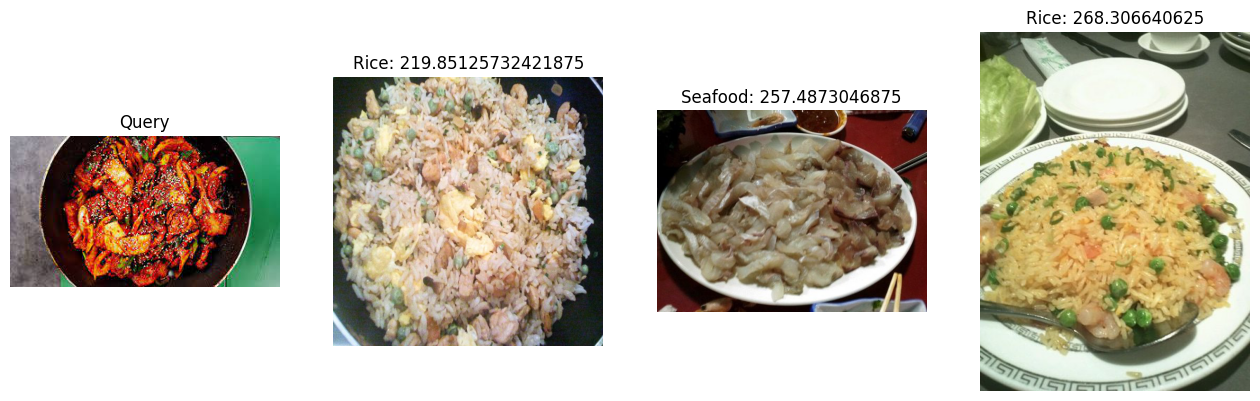

In [ ]:
query("/content/test/images.jpg")